<a href="https://colab.research.google.com/github/krdpk17/first_simple_network/blob/main/Erav1_assignment_7_s2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step-2

Further decrease the parameter count

---



In [ ]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
import matplotlib.pyplot as plt

In [ ]:

# Transforms for training data
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])

# Transforms for testing data
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,),(0.3081,))
])



In [ ]:
#download train and test data
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9912422/9912422 [00:00<00:00, 103209073.91it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 47392681.46it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 27519145.11it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 8099714.61it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [ ]:
#check if cuda available
cuda = torch.cuda.is_available()
print('cuda available = ', cuda)

cuda available =  True


In [ ]:
#for reproducibility
SEED = 1
torch.manual_seed(SEED)
print("Cuda=", cuda)
if cuda:
  torch.cuda.manual_seed(SEED)

Cuda= True


In [ ]:
#data loader
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

train_loader = torch.utils.data.DataLoader(train, **dataloader_args)
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [ ]:
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 11
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=10, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU()
        ) # output_size = 8

        # OUTPUT BLOCK
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1X1*16

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False)
        ) # output_size = 6
        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.dropout(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.gap(x)
        x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [ ]:
from torchsummary import summary

device = torch.device("cuda" if cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             144
              ReLU-2           [-1, 16, 26, 26]               0
       BatchNorm2d-3           [-1, 16, 26, 26]              32
           Dropout-4           [-1, 16, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           2,304
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9           [-1, 10, 24, 24]             160
          Dropout-10           [-1, 10, 24, 24]               0
        MaxPool2d-11           [-1, 10, 12, 12]               0
           Conv2d-12           [-1, 16, 10, 10]           1,440
             ReLU-13           [-1, 16, 10, 10]               0
      BatchNorm2d-14           [-1

In [ ]:
#training and testing methods
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    #move data and target to device
    data, target = data.to(device), target.to(device)

    #reset gradient values to zero
    optimizer.zero_grad()

    y_pred = model(data) # prediction

    loss = F.nll_loss(y_pred, target=target) # calculate loss/error
    train_losses.append(loss)

    loss.backward() # calculate back propagation
    optimizer.step() # apply the back propagation


    pred = y_pred.argmax(dim=1, keepdim=True)
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
  model.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data, target = data.to(device), target.to(device)
      output = model(data)

      test_loss = F.nll_loss(output, target=target, reduction='sum').item()
      pred = output.argmax(dim=1, keepdim=True)
      correct += pred.eq(target.view_as(pred)).sum().item()

      test_loss /= len(test_loader.dataset)
      test_losses.append(test_loss)

  print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

  test_acc.append(100*correct/len(test_loader.dataset))


In [ ]:
from torch.optim.lr_scheduler import StepLR

#train and test the model
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

EPOCHS = 20
for epoch in range(EPOCHS):
  print("EPOCH:", epoch)
  train(model,device, train_loader=train_loader, optimizer=optimizer, epoch=epoch)
  test(model, device, test_loader= test_loader)

EPOCH: 0


Loss=0.10559022426605225 Batch_id=468 Accuracy=86.40: 100%|██████████| 469/469 [00:27<00:00, 16.81it/s]



Test set: Average loss: 0.0000, Accuracy: 9602/10000 (96.02%)

EPOCH: 1


Loss=0.05931577458977699 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0001, Accuracy: 9813/10000 (98.13%)

EPOCH: 2


Loss=0.05516202375292778 Batch_id=468 Accuracy=97.81: 100%|██████████| 469/469 [00:21<00:00, 22.11it/s]



Test set: Average loss: 0.0001, Accuracy: 9833/10000 (98.33%)

EPOCH: 3


Loss=0.06296270340681076 Batch_id=468 Accuracy=98.14: 100%|██████████| 469/469 [00:23<00:00, 19.80it/s]



Test set: Average loss: 0.0001, Accuracy: 9873/10000 (98.73%)

EPOCH: 4


Loss=0.06992211192846298 Batch_id=468 Accuracy=98.33: 100%|██████████| 469/469 [00:22<00:00, 21.14it/s]



Test set: Average loss: 0.0001, Accuracy: 9857/10000 (98.57%)

EPOCH: 5


Loss=0.029886426404118538 Batch_id=468 Accuracy=98.46: 100%|██████████| 469/469 [00:21<00:00, 22.29it/s]



Test set: Average loss: 0.0000, Accuracy: 9896/10000 (98.96%)

EPOCH: 6


Loss=0.06802626699209213 Batch_id=468 Accuracy=98.56: 100%|██████████| 469/469 [00:20<00:00, 22.73it/s]



Test set: Average loss: 0.0000, Accuracy: 9885/10000 (98.85%)

EPOCH: 7


Loss=0.06252980977296829 Batch_id=468 Accuracy=98.64: 100%|██████████| 469/469 [00:20<00:00, 22.60it/s]



Test set: Average loss: 0.0002, Accuracy: 9909/10000 (99.09%)

EPOCH: 8


Loss=0.012553003616631031 Batch_id=468 Accuracy=98.68: 100%|██████████| 469/469 [00:20<00:00, 22.58it/s]



Test set: Average loss: 0.0000, Accuracy: 9878/10000 (98.78%)

EPOCH: 9


Loss=0.03803853318095207 Batch_id=468 Accuracy=98.77: 100%|██████████| 469/469 [00:21<00:00, 21.64it/s]



Test set: Average loss: 0.0000, Accuracy: 9891/10000 (98.91%)

EPOCH: 10


Loss=0.024387620389461517 Batch_id=468 Accuracy=98.76: 100%|██████████| 469/469 [00:22<00:00, 20.82it/s]



Test set: Average loss: 0.0000, Accuracy: 9903/10000 (99.03%)

EPOCH: 11


Loss=0.016133958473801613 Batch_id=468 Accuracy=98.79: 100%|██████████| 469/469 [00:23<00:00, 20.31it/s]



Test set: Average loss: 0.0000, Accuracy: 9910/10000 (99.10%)

EPOCH: 12


Loss=0.1345171332359314 Batch_id=468 Accuracy=98.87: 100%|██████████| 469/469 [00:22<00:00, 20.40it/s]



Test set: Average loss: 0.0000, Accuracy: 9903/10000 (99.03%)

EPOCH: 13


Loss=0.05870136618614197 Batch_id=468 Accuracy=98.90: 100%|██████████| 469/469 [00:22<00:00, 20.70it/s]



Test set: Average loss: 0.0000, Accuracy: 9929/10000 (99.29%)

EPOCH: 14


Loss=0.03202361240983009 Batch_id=468 Accuracy=98.91: 100%|██████████| 469/469 [00:22<00:00, 20.84it/s]



Test set: Average loss: 0.0000, Accuracy: 9918/10000 (99.18%)

EPOCH: 15


Loss=0.009098989889025688 Batch_id=468 Accuracy=98.92: 100%|██████████| 469/469 [00:24<00:00, 19.38it/s]



Test set: Average loss: 0.0000, Accuracy: 9917/10000 (99.17%)

EPOCH: 16


Loss=0.0292102862149477 Batch_id=468 Accuracy=98.98: 100%|██████████| 469/469 [00:22<00:00, 20.44it/s]



Test set: Average loss: 0.0002, Accuracy: 9897/10000 (98.97%)

EPOCH: 17


Loss=0.04965396225452423 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 20.96it/s]



Test set: Average loss: 0.0000, Accuracy: 9914/10000 (99.14%)

EPOCH: 18


Loss=0.007411383092403412 Batch_id=468 Accuracy=98.97: 100%|██████████| 469/469 [00:22<00:00, 21.27it/s]



Test set: Average loss: 0.0000, Accuracy: 9922/10000 (99.22%)

EPOCH: 19


Loss=0.03316989913582802 Batch_id=468 Accuracy=99.01: 100%|██████████| 469/469 [00:22<00:00, 21.18it/s]



Test set: Average loss: 0.0000, Accuracy: 9928/10000 (99.28%)



Text(0.5, 1.0, 'Test Accuracy')

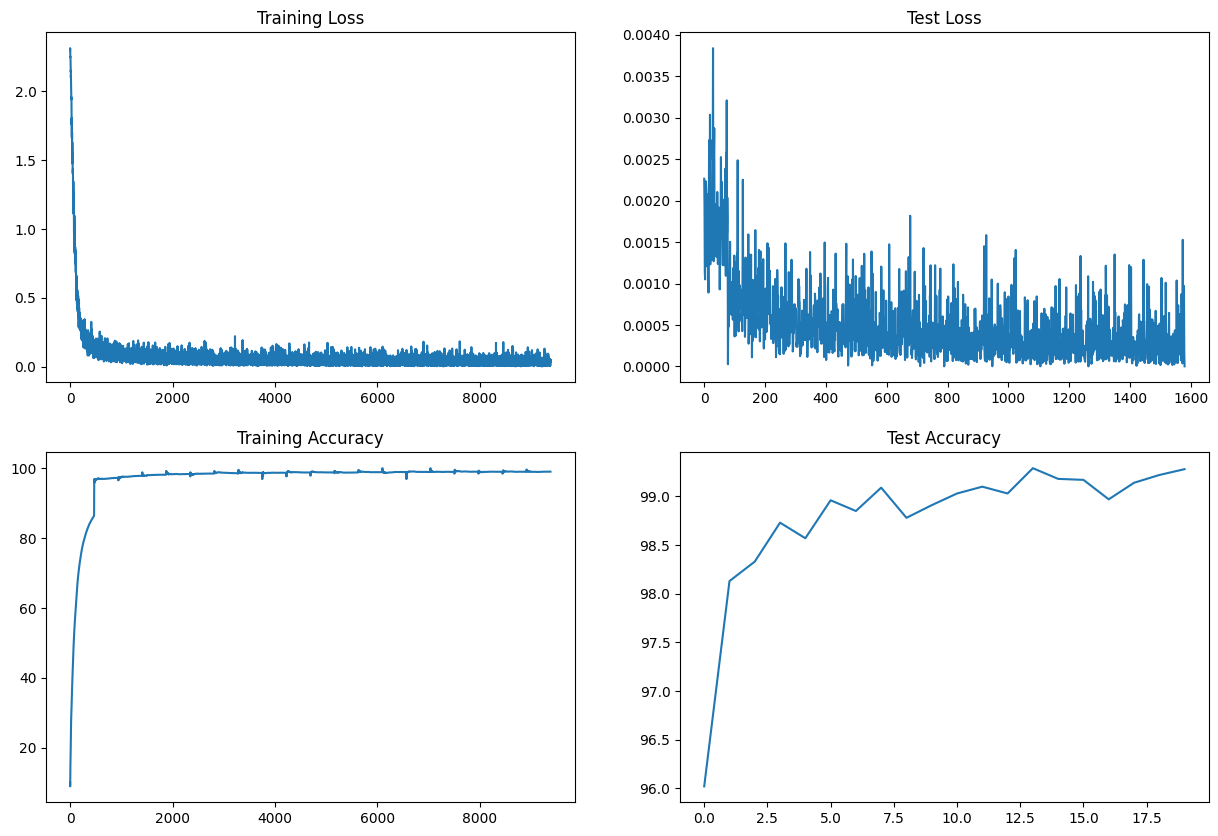

In [ ]:
t = [t_items.item() for t_items in train_losses]
%matplotlib inline
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(t)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Parameters: 8,976

Best training accuracy: 99.29

Best test accuracy:99.01

Observations

Test accuracy is consistently high
Test accuracy is attained 9.29 in 13 steps which is ok



Next step:

Try adaptive global pooling


